=== TREINAMENTO DO AGENTE Q-LEARNING NO MUNDO DE WUMPUS ===

Recompensas:
- Movimento: -1
- Pegar ouro: +1000
- Voltar à origem com ouro: +2000
- Cair em poço: -1000
- Ser morto pelo Wumpus: -1000
- Matar Wumpus: +100
- Ações inválidas: -5 a -50

Iniciando treinamento...
Episódio 0, Score médio: -1017.00, Epsilon: 0.995, Vitórias: 0
Episódio 500, Score médio: -657.12, Epsilon: 0.081, Vitórias: 48
Episódio 1000, Score médio: -569.58, Epsilon: 0.010, Vitórias: 52
Episódio 1500, Score médio: -560.48, Epsilon: 0.010, Vitórias: 53
Episódio 2000, Score médio: -546.05, Epsilon: 0.010, Vitórias: 53
Episódio 2500, Score médio: -608.67, Epsilon: 0.010, Vitórias: 53
Episódio 3000, Score médio: -531.37, Epsilon: 0.010, Vitórias: 53
Episódio 3500, Score médio: -586.09, Epsilon: 0.010, Vitórias: 53
Episódio 4000, Score médio: -566.51, Epsilon: 0.010, Vitórias: 53
Episódio 4500, Score médio: -553.63, Epsilon: 0.010, Vitórias: 53

Testando agente treinado...

=== TESTE DO AGENTE ===
Vitórias: 0/100 (0

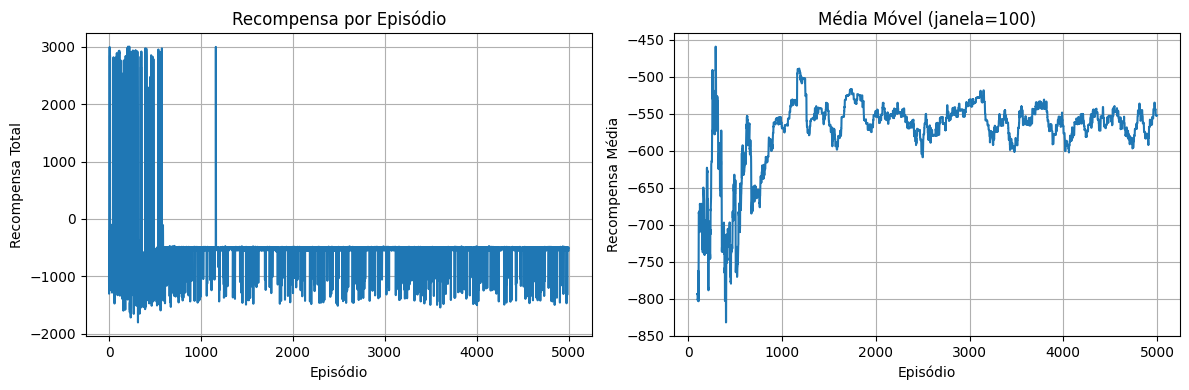

Agente salvo em wumpus_agent.pkl

Treinamento concluído!
Taxa de vitória final: 0%


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size

        self.EMPTY = 0
        self.PIT = 1
        self.WUMPUS = 2
        self.GOLD = 3
        self.AGENT = 4

        self.reset()

    def reset(self):
        """Reinicia o mundo de Wumpus com configuração aleatória"""
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.agent_pos = [0, 0]  # Posição inicial do agente
        self.agent_alive = True
        self.has_gold = False
        self.has_arrow = True
        self.wumpus_alive = True

        self._place_elements()

        return self._get_state()

    def _place_elements(self):
        """Coloca wumpus, poços e ouro no mundo"""
        positions = [(i, j) for i in range(self.size) for j in range(self.size) if (i, j) != (0, 0)]

        wumpus_pos = random.choice(positions)
        self.wumpus_pos = list(wumpus_pos)
        self.grid[wumpus_pos] = self.WUMPUS
        positions.remove(wumpus_pos)

        num_pits = random.randint(2, 3)
        for _ in range(num_pits):
            if positions:
                pit_pos = random.choice(positions)
                self.grid[pit_pos] = self.PIT
                positions.remove(pit_pos)

        if positions:
            gold_pos = random.choice(positions)
            self.gold_pos = list(gold_pos)
            self.grid[gold_pos] = self.GOLD

    def _get_state(self):
        """Retorna o estado atual do agente"""
        return (self.agent_pos[0], self.agent_pos[1],
                self.has_gold, self.wumpus_alive, self.has_arrow)

    def get_percepts(self):
        """Retorna as percepções do agente na posição atual"""
        x, y = self.agent_pos
        percepts = {
            'stench': False,
            'breeze': False,
            'glitter': False,
            'bump': False,
            'scream': False
        }

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < self.size and 0 <= ny < self.size and
                [nx, ny] == self.wumpus_pos and self.wumpus_alive):
                percepts['stench'] = True
                break

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < self.size and 0 <= ny < self.size and
                self.grid[nx, ny] == self.PIT):
                percepts['breeze'] = True
                break

        if [x, y] == self.gold_pos and not self.has_gold:
            percepts['glitter'] = True

        return percepts

    def step(self, action):
        """Executa uma ação e retorna (próximo_estado, recompensa, terminado)"""
        if not self.agent_alive:
            return self._get_state(), -1000, True

        reward = -1
        done = False

        x, y = self.agent_pos

        # Ações: 0=Norte, 1=Sul, 2=Leste, 3=Oeste, 4=Pegar, 5=Atirar
        if action == 0:
            new_x, new_y = max(0, x - 1), y
        elif action == 1:
            new_x, new_y = min(self.size - 1, x + 1), y
        elif action == 2:
            new_x, new_y = x, min(self.size - 1, y + 1)
        elif action == 3:
            new_x, new_y = x, max(0, y - 1)
        elif action == 4:
            if [x, y] == self.gold_pos and not self.has_gold:
                self.has_gold = True
                reward = 1000
                if [x, y] == [0, 0]:
                    done = True
                    reward = 2000
            else:
                reward = -10  # Penalidade por tentar pegar quando não há ouro
            new_x, new_y = x, y
        elif action == 5:  # Atirar flecha
            if self.has_arrow:
                self.has_arrow = False
                # Atirar na direção que o agente está "olhando" (simplificado: Norte)
                target_x, target_y = x - 1, y
                if ([target_x, target_y] == self.wumpus_pos and
                    0 <= target_x < self.size and self.wumpus_alive):
                    self.wumpus_alive = False
                    reward = 100
                else:
                    reward = -50  # Penalidade por desperdiçar flecha
            else:
                reward = -10  # Tentar atirar sem flecha
            new_x, new_y = x, y
        else:
            new_x, new_y = x, y

        if action in [0, 1, 2, 3]:
            if new_x == x and new_y == y:
                reward = -5
            else:
                self.agent_pos = [new_x, new_y]

                if self.grid[new_x, new_y] == self.PIT:
                    self.agent_alive = False
                    reward = -1000
                    done = True

                elif ([new_x, new_y] == self.wumpus_pos and self.wumpus_alive):
                    self.agent_alive = False
                    reward = -1000
                    done = True

                elif [new_x, new_y] == [0, 0] and self.has_gold:
                    reward = 2000
                    done = True

        return self._get_state(), reward, done


class QLearningAgent:
    def __init__(self, actions=6, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.actions = actions  # 0-3: movimento, 4: pegar, 5: atirar
        self.alpha = alpha      # Taxa de aprendizado
        self.gamma = gamma      # Fator de desconto
        self.epsilon = epsilon  # Exploração
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.q_table = {}

    def get_action(self, state):
        """Escolhe ação usando política epsilon-greedy"""
        if random.random() < self.epsilon:
            return random.randint(0, self.actions - 1)
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.actions)
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        """Atualiza Q-table usando Q-learning"""
        # Inicializar estados se não existirem
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.actions)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.actions)

        current_q = self.q_table[state][action]
        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state])

        self.q_table[state][action] = current_q + self.alpha * (target_q - current_q)

    def decay_epsilon(self):
        """Reduz epsilon para diminuir exploração ao longo do tempo"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_agent(episodes=5000, max_steps=100):
    """Treina o agente Q-learning no mundo de Wumpus"""
    env = WumpusWorld(size=4)
    agent = QLearningAgent()

    scores = []
    wins = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)

            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if done:
                if reward > 1000:
                    wins += 1
                break

        scores.append(total_reward)
        agent.decay_epsilon()

        if episode % 500 == 0:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            print(f"Episódio {episode}, Score médio: {avg_score:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}, Vitórias: {wins}")

    return agent, scores


def test_agent(agent, episodes=100):
    """Testa o agente treinado"""
    env = WumpusWorld(size=4)
    wins = 0
    total_rewards = []

    original_epsilon = agent.epsilon
    agent.epsilon = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward

            if done:
                if reward > 1000:
                    wins += 1
                break

        total_rewards.append(total_reward)

    # Restaurar epsilon original
    agent.epsilon = original_epsilon

    print(f"\n=== TESTE DO AGENTE ===")
    print(f"Vitórias: {wins}/{episodes} ({wins/episodes*100:.1f}%)")
    print(f"Score médio: {np.mean(total_rewards):.2f}")
    print(f"Score máximo: {np.max(total_rewards)}")
    print(f"Score mínimo: {np.min(total_rewards)}")

    return wins, total_rewards


def visualize_training(scores):
    """Visualiza o progresso do treinamento"""
    plt.figure(figsize=(12, 4))

    # Gráfico de scores
    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title('Recompensa por Episódio')
    plt.xlabel('Episódio')
    plt.ylabel('Recompensa Total')
    plt.grid(True)

    # Média móvel
    plt.subplot(1, 2, 2)
    window_size = 100
    if len(scores) >= window_size:
        moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(scores)), moving_avg)
        plt.title(f'Média Móvel (janela={window_size})')
        plt.xlabel('Episódio')
        plt.ylabel('Recompensa Média')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def save_agent(agent, filename='wumpus_agent.pkl'):
    """Salva o agente treinado"""
    agent_data = {
        'actions': agent.actions,
        'alpha': agent.alpha,
        'gamma': agent.gamma,
        'epsilon': agent.epsilon,
        'epsilon_decay': agent.epsilon_decay,
        'epsilon_min': agent.epsilon_min,
        'q_table': dict(agent.q_table)
    }

    with open(filename, 'wb') as f:
        pickle.dump(agent_data, f)
    print(f"Agente salvo em {filename}")


def load_agent(filename='wumpus_agent.pkl'):
    """Carrega um agente treinado"""
    with open(filename, 'rb') as f:
        agent_data = pickle.load(f)

    # Recriar o agente
    agent = QLearningAgent(
        actions=agent_data['actions'],
        alpha=agent_data['alpha'],
        gamma=agent_data['gamma'],
        epsilon=agent_data['epsilon'],
        epsilon_decay=agent_data['epsilon_decay']
    )
    agent.epsilon_min = agent_data['epsilon_min']
    agent.q_table = agent_data['q_table']

    print(f"Agente carregado de {filename}")
    return agent


if __name__ == "__main__":
    print("=== TREINAMENTO DO AGENTE Q-LEARNING NO MUNDO DE WUMPUS ===")
    print("\nRecompensas:")
    print("- Movimento: -1")
    print("- Pegar ouro: +1000")
    print("- Voltar à origem com ouro: +2000")
    print("- Cair em poço: -1000")
    print("- Ser morto pelo Wumpus: -1000")
    print("- Matar Wumpus: +100")
    print("- Ações inválidas: -5 a -50")

    print("\nIniciando treinamento...")
    agent, scores = train_agent(episodes=5000)

    print("\nTestando agente treinado...")
    wins, test_scores = test_agent(agent, episodes=100)

    visualize_training(scores)

    save_agent(agent)

    print(f"\nTreinamento concluído!")
    print(f"Taxa de vitória final: {wins}%")